In [30]:
#Imports
%matplotlib inline
import numpy as np
import mkl
import matplotlib.pyplot as plt

from scipy import misc
from scipy import ndimage
import matplotlib.cm as cm

import sys
def isneeded(x):
    if x not in sys.path:
        sys.path.append(x)

isneeded('/Users/curt/openMSI_SVN/openmsi-tk/')
isneeded('/Users/curt/openMSI_localdata/')

from omsi.dataformat.mzml_file import *

In [2]:
#Reading the MS2 image file and building a list of datacubes
omsi_ms2 = mzml_file(basename="/Users/curt/openMSI_localdata/CF_20150522_CamKath_PhenazineNPs_TI.mzML")

Read 324 scans from mzML file.
Found 9 different scan types in mzML file.
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 100.00@cid35.00 [50.00-2000.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 269.06@hcd60.00 [50.00-275.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 400.15@hcd60.00 [50.00-405.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 342.11@hcd60.00 [50.00-345.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 175.06@cid60.00 [50.00-180.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 225.07@hcd60.00 [50.00-230.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 181.08@hcd60.00 [50.00-185.00]
Processed data for 0 spectra to datacube for scan type FTMS + p MALDI Full ms2 384.16@hcd60.00 [50.00-390.00]
Processed data for 0 spectra to datacube for 

In [8]:
#extract desired data from omsi_ms2 in preparation for deleting it

mz = omsi_ms2.mz_all[1::]

# the first "MS1" channel is a mistake and is useless; 
# it probably takes up a disproportionate fraction of memory because it has a big m/z range and higher nom. resolution
dat = omsi_ms2.data[1::]   

scantypes = omsi_ms2.scan_types[1::]

[  50.           50.00013351   50.00026703 ...,  274.99980927  274.99994278
  275.        ]


In [5]:
[omsi_ms2.data[scan].nbytes for scan in xrange(0, len(omsi_ms2.data))]

[82811290896,
 2184036048,
 3445922736,
 2863513296,
 1261887984,
 1747229616,
 1310421888,
 3300319728,
 1141310736]

In [9]:
del omsi_ms2

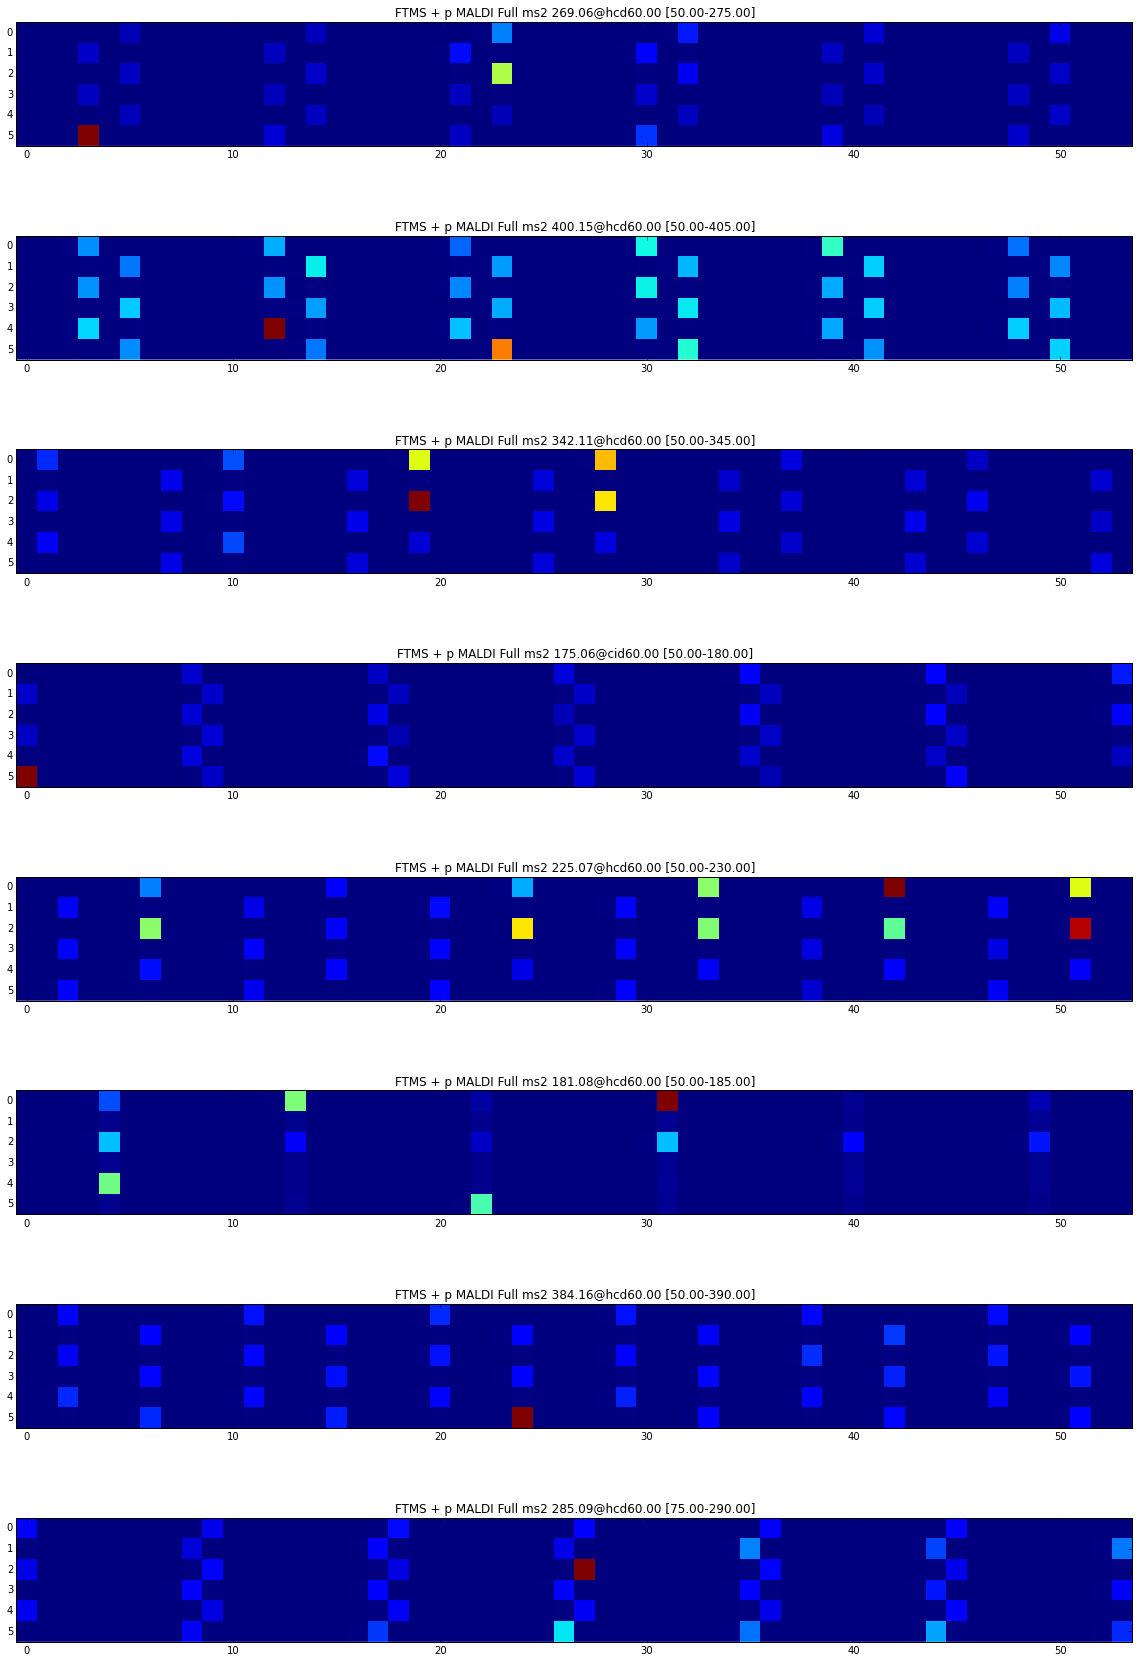

In [11]:
# TIC image plots for each MS2 scan type

nplots = len(dat)
f, ax = plt.subplots(nplots, 1, figsize=[20, 30])
for dim in xrange(0, len(dat)):
    ax[dim].imshow(dat[dim][:, :, :].sum(axis=2).T, interpolation='none')
    ax[dim].set_title(scantypes[dim])

In [19]:
img_size = [(dat[dim].shape[0], dat[dim].shape[1]) for dim in xrange(0, nplots)]
# spectral plots at pixel with maximum TIC intensity for each channel
maxPix = [np.unravel_index(dat[dim][:, :, :].sum(axis=2).argmax(), img_size[dim]) for dim in xrange(0, nplots)]

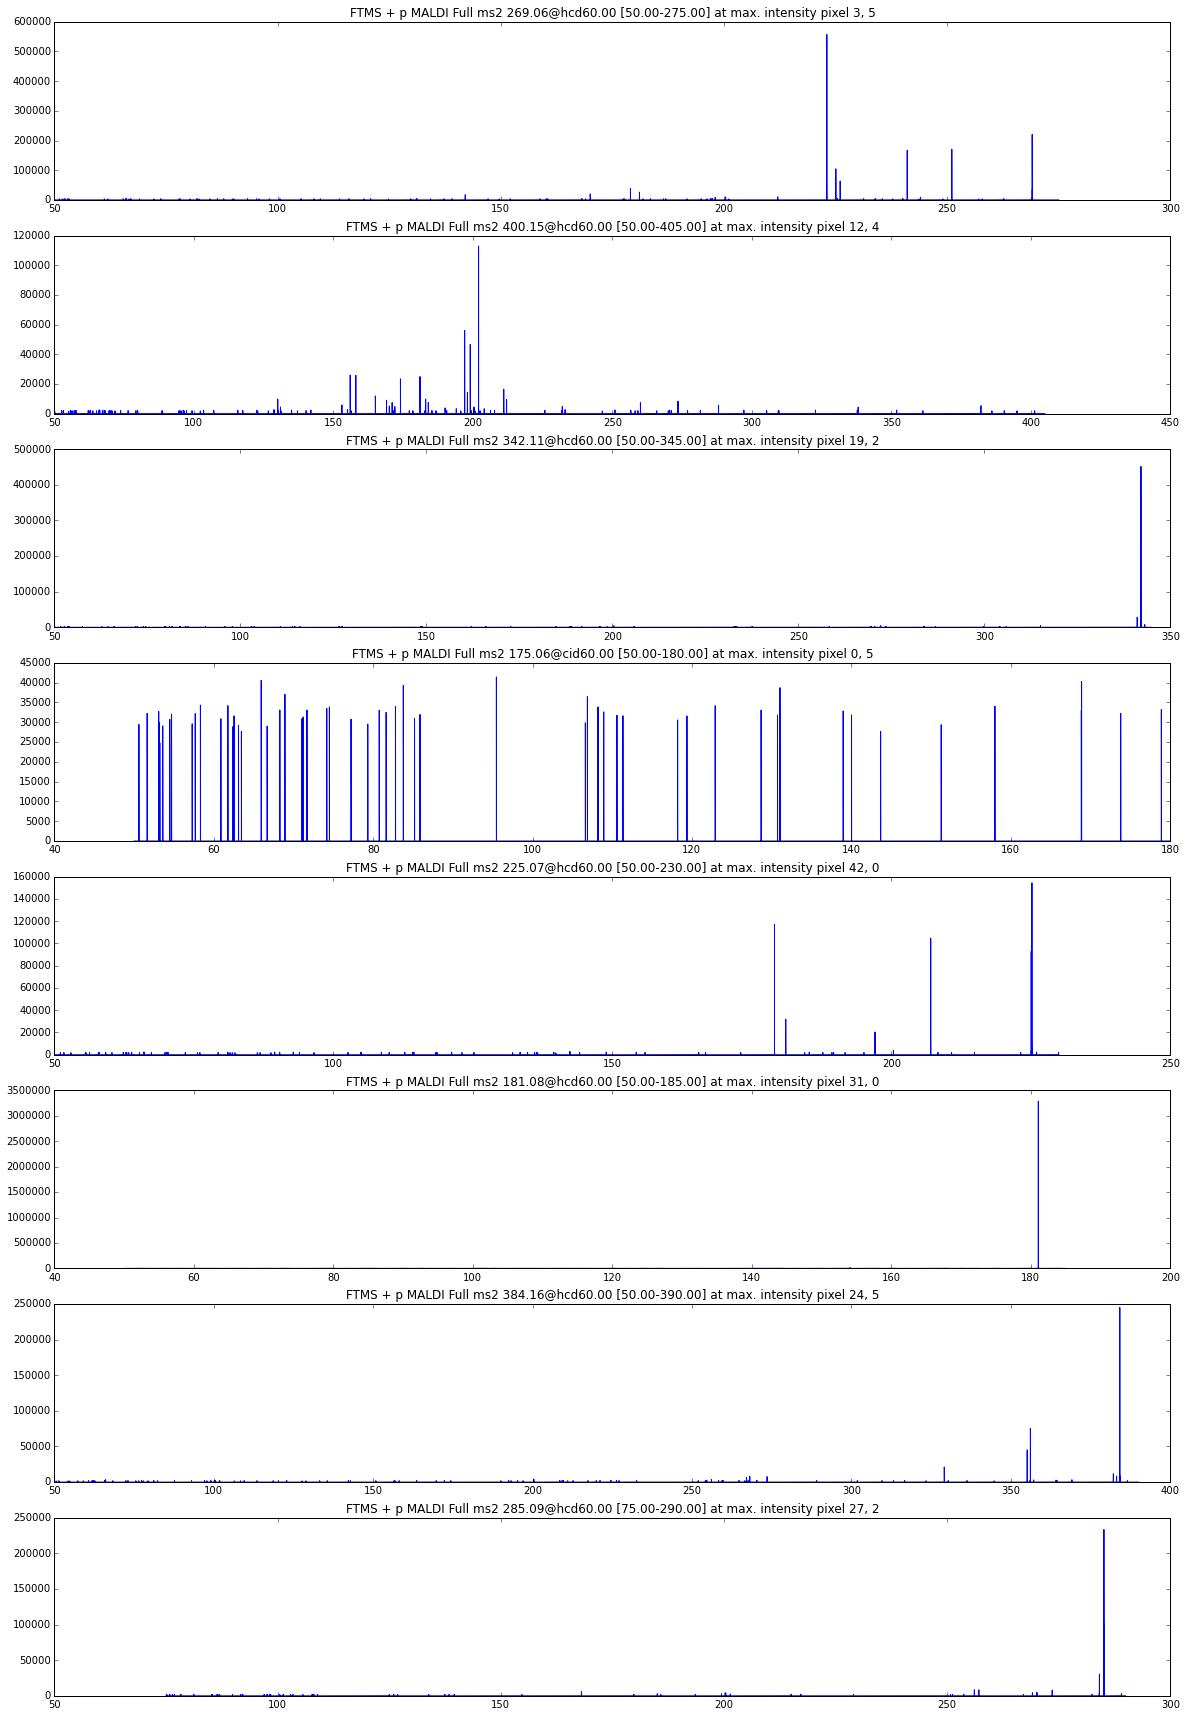

In [22]:
f, ax = plt.subplots(nplots, 1, figsize=[20, 30])
for dim in xrange(0, len(dat)):
    xbest, ybest = maxPix[dim]
    ax[dim].plot(mz[dim], dat[dim][xbest, ybest, :])
    ax[dim].set_title(scantypes[dim] + ' at max. intensity pixel %s, %s' % (xbest, ybest))

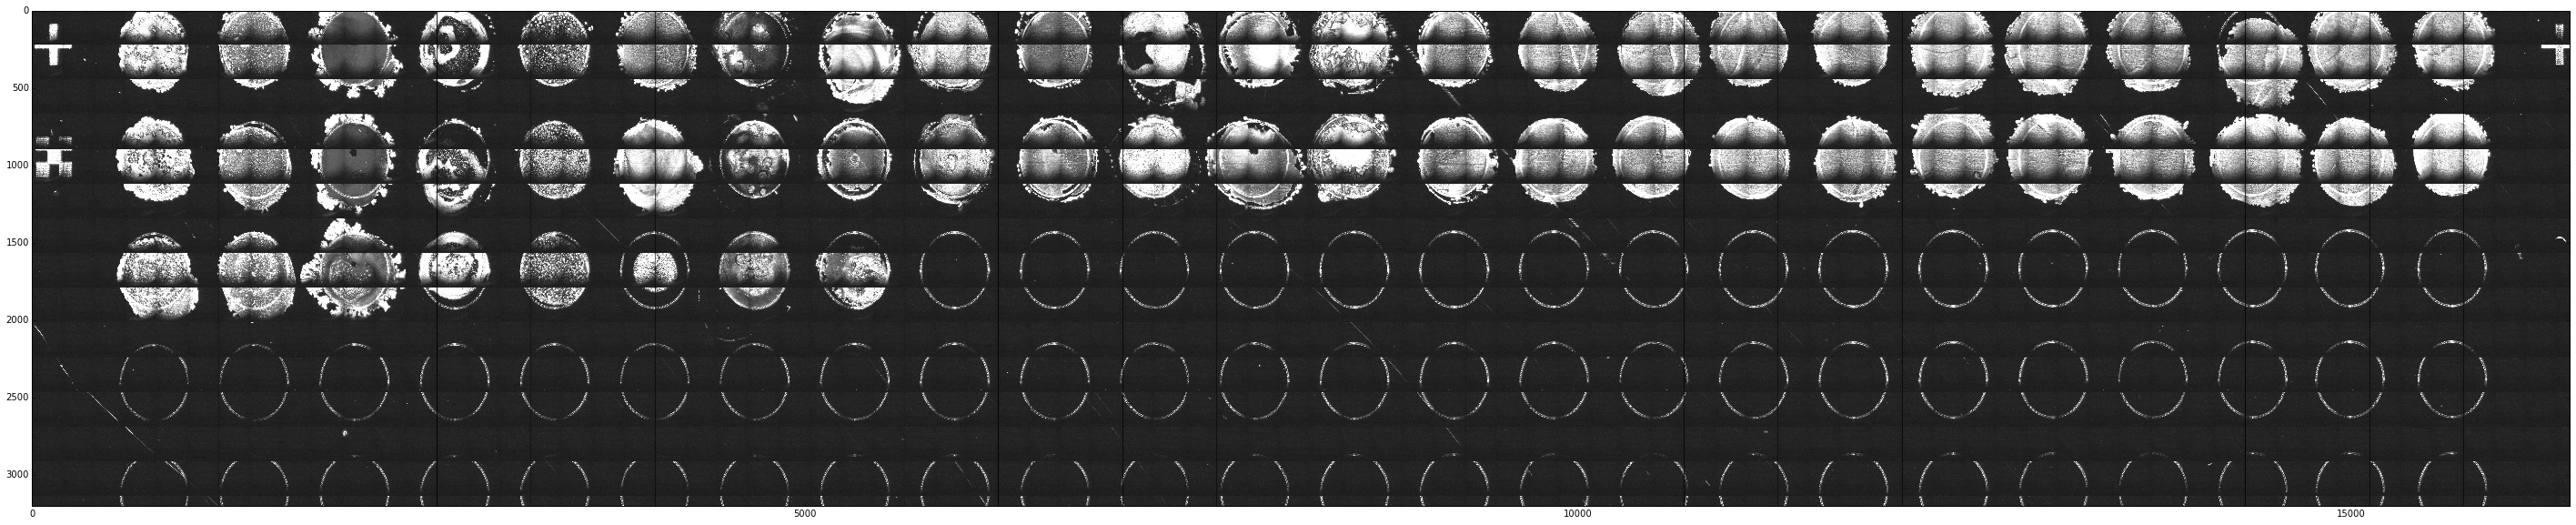

In [28]:
# A photo of the relevant region of the plate

photo = ndimage.imread('/Users/curt/openMSI_localdata/Cam_phen_plate_optic_CF.bmp')
plt.figure(figsize=(50,25))
f = plt.imshow(photo, cmap=cm.Greys_r)

In [44]:
# TICsum image
TICsum = sum([dat[dim].sum(axis=2) for dim in xrange(0, len(dat))])


(54, 6)
(3200, 16416)


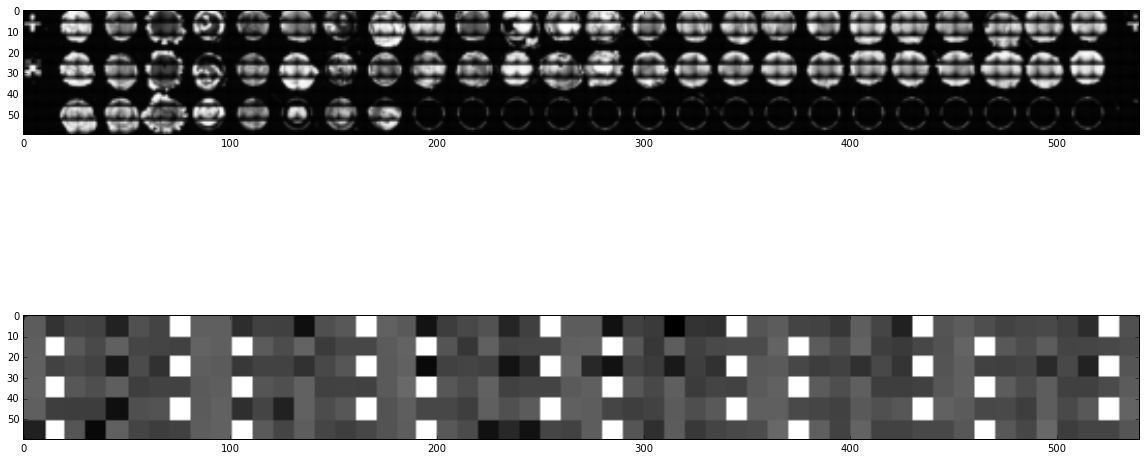

In [69]:
# smoothed TICsum image
newshape = [10*x for x in TICsum.T.shape]

TICsumMed = misc.imresize(-np.log10(TICsum.T+100), newshape, interp='nearest')
photoMed = misc.imresize(photo[0:2000,:], newshape)  #optical image shows more of plate than MS image did

f, ax = plt.subplots(2, 1, figsize=[20, 10])
ax[0].imshow(photoMed, cmap=cm.Greys_r)
ax[1].imshow(TICsumMed, cmap=cm.Greys_r)

{'scale': 1.1833511417481499, 'angle': -180.0, 'tvec': array([  0, 157]), 'success': 0.058766899891370371, 'Dscale': 0.0038435376579434343, 'Dt': 0.5, 'Dangle': 0.16666666666666666, 'timg': array([[ 65.73462081,  66.03712778,  66.26095464, ...,  65.02028988,
         64.99817743,  64.9981011 ],
       [ 64.69751548,  65.49215642,  65.93402926, ...,  65.01957693,
         64.9975065 ,  64.9973756 ],
       [ 64.39872561,  65.15789271,  65.68106442, ...,  65.01931127,
         64.99771434,  64.99683256],
       ..., 
       [ 68.92318878,  67.56896614,  67.16928806, ...,  78.99294679,
         78.94248829,  79.05376352],
       [ 68.63239322,  67.25371956,  66.93713236, ...,  79.00634826,
         78.95580382,  79.0673582 ],
       [ 67.59911784,  66.71694497,  66.61951829, ...,  79.00482918,
         78.95429687,  79.06580945]])}


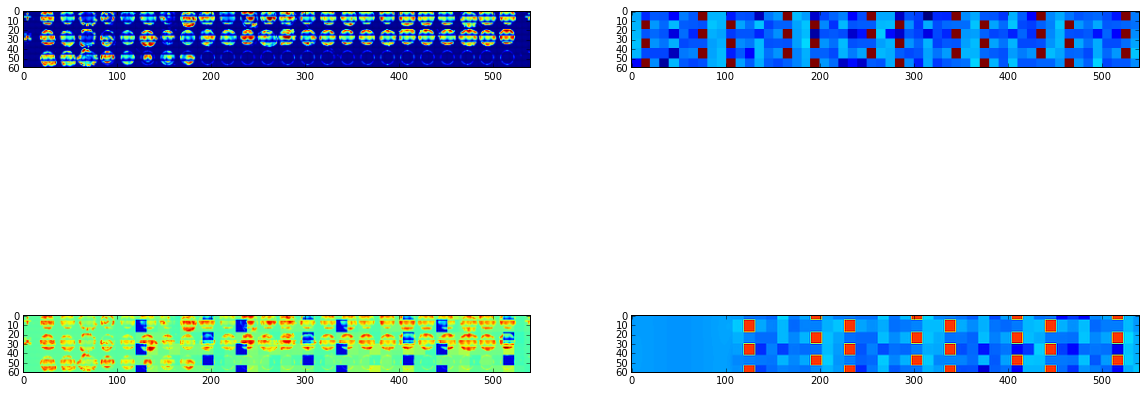

In [70]:
# Image registration: eventually we would like to overlay the optical photo with mass spec images, 
# but the low-res mass spec image is not good enough for this purpose

import imreg_dft as ird

result = ird.similarity(photoMed, TICsumMed, numiter=20)

f, axarr = plt.subplots(2, 2, figsize=[20, 10])
axarr[0, 0].imshow(photoMed)
axarr[0, 1].imshow(TICsumMed)
axarr[1, 0].imshow(photoMed-result['timg'])
axarr[1, 1].imshow(result['timg'])
print result
